## Analysing A subset of data from Experiment 68 (166K-member Level 3 library)

- Python version


In [17]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wimpy as wp

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading input data

Reference sequences

In [24]:
# reference sequences from input fasta file
with open(r"./info/ref_sequences.fasta") as ref_fasta_file:
    ref_seqs = {
        record.id: str(record.seq) for record in SeqIO.parse(ref_fasta_file, "fasta")
    }
    
Puro = ref_seqs['Puro']
GFP = ref_seqs['GFP'][-100:]
A4 = ref_seqs['A4'][-50:]
minP = ref_seqs['minP']
mRuby = ref_seqs['mRuby'][200:300]
BFP = ref_seqs['BFP'][200:300]
ZF_parts = [ref_seqs['WT'], ref_seqs['C1_WT'], ref_seqs['C1_6x']]

# reference sequences from excel files
minP_100k = pd.read_excel(r'./info/100k_Minimal-Promoters.xlsx')['Sequence'].to_list()
terminators_100k = pd.read_excel(r'./info/100k_terminators.xlsx')['Sequence'].to_list()
promoters_100k = pd.read_excel(r'./info/100k-Promoters.xlsx')['Sequence'].to_list()
AD_parts = pd.read_excel(r'./info/100k_ORF-Parts_SynTF.xlsx').loc[0:3, 'SEQUENCE'].to_list()


Loading input Nanopore sequencing files, initial aliment with `bowtile`, and filter based on read length

In [19]:
# load in data
_, l, seqs = wp.fastqall('./fastq/')
l, seqs = np.array(l), np.array(seqs)

# filter based on read length
seqs = seqs[(l > 9500) & (l < 15000)]
l = l[(l > 9500) & (l < 15000)]


reading fastq files: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


In [20]:
# bowtile for alignment
new_seq, _, _ = wp.bowtile(seqs, Puro, thresh=0.03)
new_seq = np.array(new_seq)

# filter out failed attempts
reads_correct = new_seq[new_seq != '']
l_reads_correct = l[new_seq != '']

bowtile progress: 100%|██████████| 11063/11063 [01:06<00:00, 166.13it/s]


### Reporter Identification

Locate A4, GFP, and Minimal Promoter region via TILING

In [25]:
_, positions_GFP, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
_, positions_mRuby, _ = wp.tilepin_v2(reads_correct, mRuby, thresh=0.03, verbose=True)
_, positions_A4, _ = wp.tilepin_v2(reads_correct, A4, thresh=0.03, verbose=True)
_, positions_minP, _ = wp.tilepin_v2(reads_correct, minP, thresh=0.03, verbose=True)
_, positions_BFP, _ = wp.tilepin_v2(reads_correct, BFP, thresh=0.03, verbose=True)

match sequences to reference: 100%|██████████| 11025/11025 [00:14<00:00, 749.25it/s]


Assessing reporter diversity

In [26]:
# pregions and tregions using chophat
p_regions = wp.chophat(reads_correct, positions_A4, end_positions=positions_GFP)
t_regions = wp.chophat(reads_correct, positions_GFP, max_length=2000)


Assign minimal promoters

In [27]:
thresh = 0.2
minP_variants, minP_variants_counts, minPconf = wp.viscount(p_regions, minP_100k, thresh, tile_len=6, verbose=True)
minP_assignment = np.argmax(minP_variants, axis=1)
minP_assignment[np.sum(minP_variants, axis=1) < thresh] = -1

matching to reference sequences: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Assign number of binding sites based on the length of sequence

In [28]:
bs_assignment = np.zeros(len(reads_correct)) - 1
dist = positions_minP - positions_A4
bs_assignment[(dist > 0) & (dist < 160)] = 0 # 2 binding sites
bs_assignment[(dist > 160) & (dist < 255)] = 1 # 4 binding sites
bs_assignment[(dist > 255) & (dist < 415)] = 2 # 8 binding sites
bs_assignment[(dist > 415) & (dist < 555)] = 3 # 12 binding sites


Assign terminators

In [29]:
_, term_variants_counts = wp.viscount(t_regions, terminators_100k, 0.2, return_confusion_matrix=False, verbose=True)

# custom scaling of terminators
term_variants_counts[:, 1] -= term_variants_counts[:, 0] * 1.5
term_variants_counts[:, 2] -= term_variants_counts[:, 1]
term_variants_counts[term_variants_counts < 10] = 0

term_assignment = np.argmax(term_variants_counts, axis=1)
term_assignment[np.sum(term_variants_counts, axis=1) < 1] = -1


matching to reference sequences: 100%|██████████| 12/12 [03:34<00:00, 17.90s/it]


Combine assignment for the reporter

In [33]:
reporter_assignment = np.stack([bs_assignment, minP_assignment, term_assignment]).T

### SynTF Identification

Promoters

In [50]:
thresh = 0.03
pregions_synTF = wp.chophat(reads_correct, np.zeros_like(positions_minP), positions_minP)
synTF_prom_variants, _, synTF_prom_conf = wp.viscount(pregions_synTF, promoters_100k, thresh=thresh, verbose=True)
synTF_prom_assignment = np.argmax(synTF_prom_variants, axis=1)
synTF_prom_assignment[np.sum(synTF_prom_variants, axis=1) < thresh] = -1

matching to reference sequences: 100%|██████████| 4/4 [04:17<00:00, 64.39s/it]


ORF parts

In [79]:
AD_count, AD_match = [], []
for AD_part in AD_parts:
    count, _, match = wp.tilepin_v2(pregions_synTF, AD_part, thresh=1, verbose=True)
    AD_count.append(count)
    AD_match.append(match)
AD_count, AD_match = np.array(AD_count), np.array(AD_match)

# Match mRuby index to AD indices
mRuby_count, _, mRuby_match = wp.tilepin_v2(pregions_synTF, mRuby[:50], thresh=1, verbose=True)


match sequences to reference: 100%|██████████| 11025/11025 [00:06<00:00, 1577.19it/s]


In [80]:
# activation domain confusion matrix
AD_conf = np.zeros((len(AD_parts), len(AD_parts)))

for i in range(len(AD_parts)):
    for j in range(len(AD_parts)):
        AD_conf[i, j] = np.sum((AD_count[i, :] > 30) & (AD_count[j, :] > 30))

# sequence-specific adjustments
AD_conf[3, 3] = np.sum((AD_count[3, :] > 10) & (AD_count[2, :] < 100))
AD_conf[2, 2] = np.sum(AD_count[2, :] > 100)
AD_conf[2, 3] = np.sum((AD_count[3, :] < 10) & (AD_count[2, :] > 100))
AD_conf[3, 2] = AD_conf[2, 3]

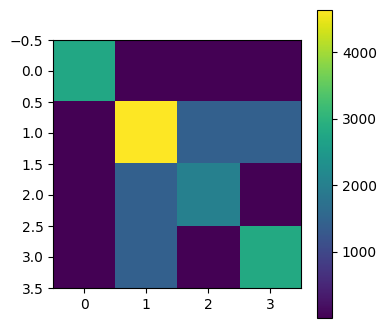

In [81]:
plt.figure(figsize=(4, 4))
plt.imshow(AD_conf)
plt.colorbar()
plt.show()

Assigning AD variants

In [82]:
AD_count[AD_count < 30] = 0
AD_assignment = np.argmax(AD_count, axis=0)
AD_assignment[np.sum(AD_count, axis=0) == 0] = -1


Identifying end position of AD for each read

In [86]:
AD_match.shape

(4, 11025, 12240)

In [ ]:
#! WIP
AD_position = np.zeros(len(AD_count))

for i in range(len(AD_assignment)):
    if AD_assignment[i] > 0:
        b = AD_match[AD_assignment[i]]

    

In [93]:
b.shape

(11025, 12240)

-------------------------

**Performance comparision** (benchmark machine: Apple M1 Macbook Air):
- MatLab version of `tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 2 min for whole GFP reference sequence
- `wp.tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 6 min for whole GFP reference sequence
- `wp.tilepin_v2()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 18 s for whole GFP reference sequence


In [ ]:
_, positionsGFP1, _ = wp.tilepin(reads_correct, GFP, thresh=0.03, verbose=True)
_, positionsGFP2, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
plt.figure()
plt.hist(positionsGFP1 - positionsGFP2, bins=np.arange(-50, 50), cumulative=True)
plt.show()
